# Predicting Flight Ticket Price

## Importing basic libraries

In [3]:
import numpy as np
np.set_printoptions(precision=4)

import pandas as pd
pd.set_option('mode.chained_assignment', None)

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(10, 6))

In [5]:
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [8]:
from sklearn.model_selection import GridSearchCV

## Importing the training dataset

In [77]:
df = pd.read_excel('data/Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Analyzing and Modifying the training dataset

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
Airline            10683 non-null object
Date_of_Journey    10683 non-null object
Source             10683 non-null object
Destination        10683 non-null object
Route              10682 non-null object
Dep_Time           10683 non-null object
Arrival_Time       10683 non-null object
Duration           10683 non-null object
Total_Stops        10682 non-null object
Additional_Info    10683 non-null object
Price              10683 non-null int64
dtypes: int64(1), object(10)
memory usage: 500.8+ KB


In [79]:
df[df.Total_Stops.isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [80]:
df = df.dropna()
df.Total_Stops.isnull().sum()

0

In [81]:
len(df.Airline.unique())

12

In [82]:
df.Airline.value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [83]:
len(df.Date_of_Journey.unique())

44

In [84]:
len(df.Source.unique())

5

In [85]:
df.Source.value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [86]:
len(df.Destination.unique())

6

In [87]:
df.Destination.value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [88]:
len(df.Route.unique())

128

In [89]:
len(df.Dep_Time.unique())

222

In [90]:
len(df.Arrival_Time.unique())

1343

In [91]:
len(df.Duration.unique())

368

In [92]:
len(df.Total_Stops.unique())

5

In [93]:
df.Total_Stops.value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [94]:
# Converting to ordinal values 
stops = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
df.Total_Stops = df.Total_Stops.map(stops)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302


In [95]:
df.Total_Stops.value_counts()

1    5625
0    3491
2    1520
3      45
4       1
Name: Total_Stops, dtype: int64

In [96]:
len(df.Additional_Info.unique())

10

In [97]:
df.Additional_Info.value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [98]:
# Merging two values which are different only in the case of the word 'Info' ie. 'info'/'Info'
df.Additional_Info = df.Additional_Info.str.replace('Info', 'info')
df.Additional_Info.value_counts()

No info                         8347
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [ ]:
# A longer way to convert Duration into minutes
'''
df['Duration_In_Minutes'] = df['Duration'].str.replace('m', '')
df['Duration_In_Minutes'] = df['Duration_In_Minutes'].str.replace('h ', ' ')
df['Duration_In_Minutes'] = df['Duration_In_Minutes'].str.replace('h', ' 00')

def duration_in_mins(text):
    if ' ' in text:
        t = [x.strip() for x in text.split(' ')]
        duration = int(t[0]) * 60 + int(t[1])
    else:
        duration = int(text)
    
    return duration

df['Duration_In_Minutes'] = df['Duration_In_Minutes'].apply(lambda x: duration_in_mins(x))
df.head()
'''

In [99]:
# Function to convert Duration into minutes.
def duration_in_mins(text):
    td = pd.Timedelta(text)
    duration = (td.days * 24 * 60 ) + (td.seconds / 60)
    return duration

In [100]:
# Converting Duration into minutes.
df['Duration_In_Minutes'] = df['Duration'].apply(lambda x: duration_in_mins(x))
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_In_Minutes
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,170.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,445.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882,1140.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,325.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,285.0


In [101]:
# Checking for anomalies in Duration_In_Minutes.
sorted(df.Duration_In_Minutes.unique())[:10]

[5.0, 75.0, 80.0, 85.0, 90.0, 95.0, 135.0, 140.0, 145.0, 150.0]

In [102]:
df[df.Duration_In_Minutes == 5]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_In_Minutes
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2,No info,17327,5.0


In [34]:
# Removing the anomalies in Duration_In_Minutes.
# df = df.drop([6474], axis=0)

In [103]:
# Instead of removing the row with anomaly, replacing its anomalies with a similar sample.
df[(df.Source == 'Mumbai') & (df.Destination == 'Hyderabad') & (df.Route == 'BOM → GOI → PNQ → HYD')]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_In_Minutes
3821,Air India,12/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,21:10,16:55,4h 15m,2,No info,16172,255.0
5309,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,21:10,16:55,4h 15m,2,No info,17327,255.0
5942,Air India,12/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,05:05,16:55,11h 50m,2,No info,16172,710.0
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2,No info,17327,5.0
7456,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,05:05,16:55,11h 50m,2,No info,16697,710.0
8478,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,13:30,16:55,3h 25m,2,No info,18797,205.0


In [104]:
df.iloc[6474, 5] = '21:10'
df.iloc[6474, 7] = '4h 15m'
df.iloc[6474, 11] = 255.0

In [105]:
# Creating a bunch of new features from the Date_Of_Journey column.
df['Day'] = [datetime.strptime(x, '%d/%m/%Y').day for x in df.Date_of_Journey]
df['Month'] = [datetime.strptime(x, '%d/%m/%Y').month for x in df.Date_of_Journey]
df['Year'] = [datetime.strptime(x, '%d/%m/%Y').year for x in df.Date_of_Journey]
df['Date'] = [datetime.strptime(x, '%d/%m/%Y').date() for x in df.Date_of_Journey]
df['Weekday'] = [datetime.strptime(x, '%d/%m/%Y').weekday() for x in df.Date_of_Journey]
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_In_Minutes,Day,Month,Year,Date,Weekday
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,170.0,24,3,2019,2019-03-24,6
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,445.0,1,5,2019,2019-05-01,2
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882,1140.0,9,6,2019,2019-06-09,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,325.0,12,5,2019,2019-05-12,6
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,285.0,1,3,2019,2019-03-01,4


In [50]:
# df['Date'] = pd.to_datetime(df['Date'])

In [106]:
# Creating a new feature for the weekday of the Date_Of_Journey.
weekday = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['Day_Of_Week'] = df['Weekday'].map(weekday)

In [107]:
# Creating a feature assessing whether the weekday is weekend or not.
weekend_or_not = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1}
df['Weekend_Or_Not'] = df['Weekday'].map(weekend_or_not)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_In_Minutes,Day,Month,Year,Date,Weekday,Day_Of_Week,Weekend_Or_Not
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,170.0,24,3,2019,2019-03-24,6,Sunday,1
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,445.0,1,5,2019,2019-05-01,2,Wednesday,0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882,1140.0,9,6,2019,2019-06-09,6,Sunday,1
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,325.0,12,5,2019,2019-05-12,6,Sunday,1
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,285.0,1,3,2019,2019-03-01,4,Friday,0


In [ ]:
# Not gonna use these columns. Keeping them in comments for future reference.
'''
df['Time_Of_Departure'] = [parse(x).time() for x in df.Dep_Time]
df['Time_Of_Arrival'] = [parse(x).time() for x in df.Arrival_Time]
df.head()
'''

In [108]:
# Extracting Date_Of_Arrival from Arrival_Time.
# Full of '' values as of now, will try to work with it later.
df['Date_Of_Arrival'] = df.Arrival_Time.str.replace('[\d]+:[\d]+[ ]?', '')

In [109]:
# Replaced '' with 'NaN' for clarity. Still unusable.
df['Date_Of_Arrival'] = df['Date_Of_Arrival'].str.replace('\A\Z', 'NaN')

In [110]:
# Clearing the Date_Of_Arrival from Arrival_Time.
df['Arrival_Time'] = df['Arrival_Time'].str.extract('(\d+:\d+)')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_In_Minutes,Day,Month,Year,Date,Weekday,Day_Of_Week,Weekend_Or_Not,Date_Of_Arrival
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,2h 50m,0,No info,3897,170.0,24,3,2019,2019-03-24,6,Sunday,1,22 Mar
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,445.0,1,5,2019,2019-05-01,2,Wednesday,0,NaN
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,19h,2,No info,13882,1140.0,9,6,2019,2019-06-09,6,Sunday,1,10 Jun
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,325.0,12,5,2019,2019-05-12,6,Sunday,1,NaN
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,285.0,1,3,2019,2019-03-01,4,Friday,0,NaN


In [111]:
# Creating a feature which assigns a particular time period to Dep_Time and Arrival_Time 
bins = [-1, 3, 7, 11, 15, 19, 23]
time_periods = ['Late_Night', 'Early_Morning', 'Morninig_To_Noon', 'Noon_To_Evening', 'Evening_To_Night', 'Night']

In [112]:
# Dep_Time_Timeperiod divides Dep_Time into 6 different time periods.
df['Dep_Time_Timeperiod'] = pd.cut(df.Dep_Time.str.extract('(\A\d{2}):', expand=False).astype(int), bins, labels=time_periods)

In [113]:
df.Dep_Time_Timeperiod.value_counts()

Morninig_To_Noon    2728
Early_Morning       2353
Evening_To_Night    2177
Night               1692
Noon_To_Evening     1437
Late_Night           295
Name: Dep_Time_Timeperiod, dtype: int64

In [114]:
# # Arrival_Time_Timeperiod divides Arrival_Time into 6 different time periods.
df['Arrival_Time_Timeperiod'] = pd.cut(df.Arrival_Time.str.extract('(\A\d{2}):', expand=False).astype(int), bins, labels=time_periods)

In [115]:
# Encoding the different time periods into numeric values, because LabelEncoder won't handle categorical dtype.
time_period_mapping = {'Late_Night':0, 'Early_Morning':1, 'Morninig_To_Noon':2, 'Noon_To_Evening':3, 'Evening_To_Night':4, 'Night':5}
df['Dep_Time_Timeperiod_Encoded'] = df['Dep_Time_Timeperiod'].map(time_period_mapping)
df['Arrival_Time_Timeperiod_Encoded'] = df['Arrival_Time_Timeperiod'].map(time_period_mapping)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Year,Date,Weekday,Day_Of_Week,Weekend_Or_Not,Date_Of_Arrival,Dep_Time_Timeperiod,Arrival_Time_Timeperiod,Dep_Time_Timeperiod_Encoded,Arrival_Time_Timeperiod_Encoded
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,2h 50m,0,No info,...,2019,2019-03-24,6,Sunday,1,22 Mar,Night,Late_Night,5,0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,...,2019,2019-05-01,2,Wednesday,0,NaN,Early_Morning,Noon_To_Evening,1,3
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,19h,2,No info,...,2019,2019-06-09,6,Sunday,1,10 Jun,Morninig_To_Noon,Early_Morning,2,1
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,...,2019,2019-05-12,6,Sunday,1,NaN,Evening_To_Night,Night,4,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,...,2019,2019-03-01,4,Friday,0,NaN,Evening_To_Night,Night,4,5


## Exploratory Data Analysis

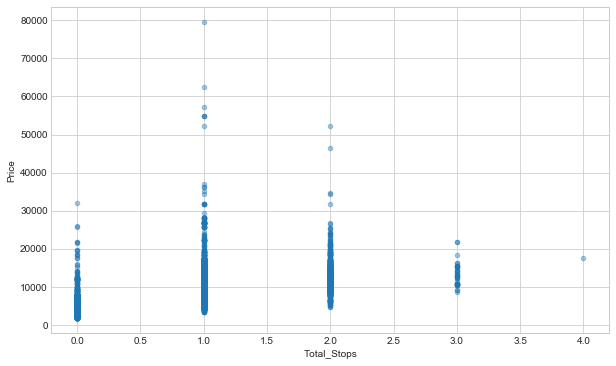

In [58]:
df.plot.scatter('Total_Stops', 'Price', alpha=0.4)

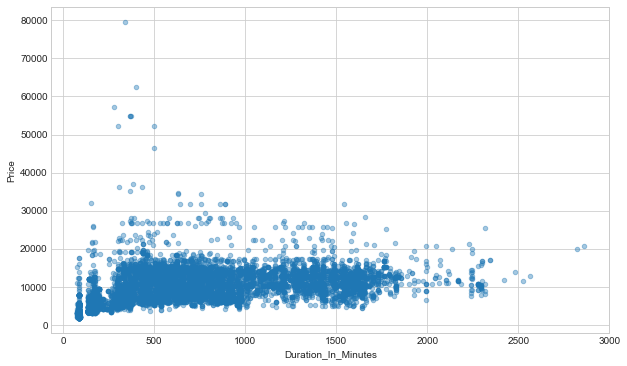

In [59]:
df.plot.scatter('Duration_In_Minutes', 'Price', alpha=0.4)

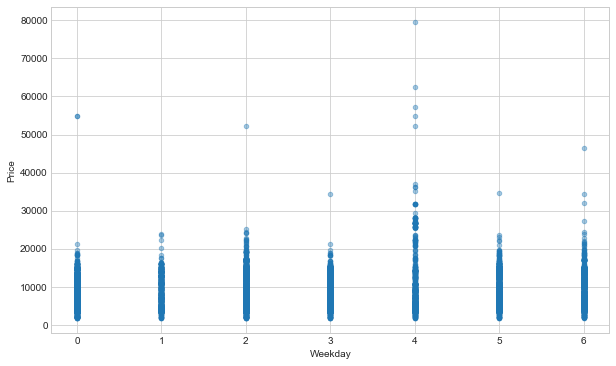

In [60]:
df.plot.scatter('Weekday', 'Price', alpha=0.4)

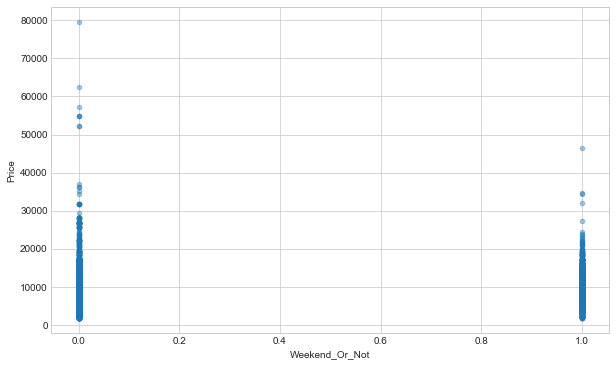

In [61]:
df.plot.scatter('Weekend_Or_Not', 'Price', alpha=0.4)

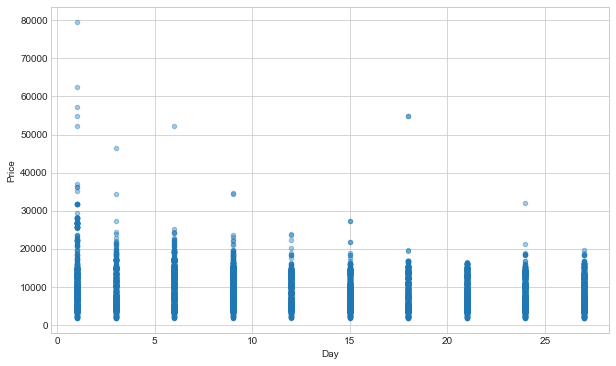

In [62]:
df.plot.scatter('Day', 'Price', alpha=0.4)

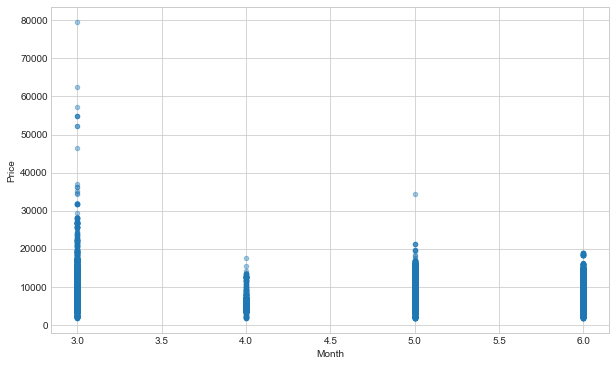

In [63]:
df.plot.scatter('Month', 'Price', alpha=0.4)

In [64]:
corr_mat = df.corr()
corr_mat

,Total_Stops,Price,Duration_In_Minutes,Day,Month,Year,Weekday,Weekend_Or_Not,Dep_Time_Timeperiod_Encoded,Arrival_Time_Timeperiod_Encoded
Total_Stops,1.000000,0.603897,0.738186,-0.009451,0.054383,NaN,-0.036750,-0.019548,-0.045127,0.032074
Price,0.603897,1.000000,0.506586,-0.153774,-0.103643,NaN,0.051570,0.020275,0.020116,0.022946
Duration_In_Minutes,0.738186,0.506586,1.000000,-0.022481,0.014769,NaN,-0.012751,-0.004173,0.024640,0.045036
Day,-0.009451,-0.153774,-0.022481,1.000000,-0.038359,NaN,-0.091245,-0.104187,-0.004639,-0.002531
Month,0.054383,-0.103643,0.014769,-0.038359,1.000000,NaN,-0.083345,-0.013189,0.036593,-0.004209
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekday,-0.036750,0.051570,-0.012751,-0.091245,-0.083345,NaN,1.000000,0.815513,-0.015155,-0.004500
Weekend_Or_Not,-0.019548,0.020275,-0.004173,-0.104187,-0.013189,NaN,0.815513,1.000000,-0.008848,-0.002309
Dep_Time_Timeperiod_Encoded,-0.045127,0.020116,0.024640,-0.004639,0.036593,NaN,-0.015155,-0.008848,1.000000,0.012049
Arrival_Time_Timeperiod_Encoded,0.032074,0.022946,0.045036,-0.002531,-0.004209,NaN,-0.004500,-0.002309,0.012049,1.000000


## Importing test set 

In [65]:
df_test = pd.read_excel('data/Test_set.xlsx')
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


## Analyzing and modifying the test set

In [66]:
df_test.Airline.value_counts()

Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Jet Airways Business                   2
Vistara Premium economy                2
Name: Airline, dtype: int64

In [67]:
df_test.Source.value_counts()

Delhi       1145
Kolkata      710
Banglore     555
Mumbai       186
Chennai       75
Name: Source, dtype: int64

In [68]:
df_test.Destination.value_counts()

Cochin       1145
Banglore      710
Delhi         317
New Delhi     238
Hyderabad     186
Kolkata        75
Name: Destination, dtype: int64

In [69]:
len(df_test.Route.unique())

100

In [70]:
df_test.Additional_Info.value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
1 Long layover                     1
Change airports                    1
Business class                     1
Name: Additional_Info, dtype: int64

In [71]:
df_test.Total_Stops = df_test.Total_Stops.map(stops)
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,0,No info


In [72]:
df_test.Total_Stops.value_counts()

1    1431
0     849
2     379
3      11
4       1
Name: Total_Stops, dtype: int64

In [73]:
df_test['Duration_In_Minutes'] = df_test['Duration'].apply(lambda x: duration_in_mins(x))
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Duration_In_Minutes
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1,No info,655.0
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1,No info,240.0
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1,In-flight meal not included,1425.0
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1,No info,780.0
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,0,No info,170.0


In [75]:
sorted(df_test.Duration_In_Minutes.unique())[:10]

[5.0, 75.0, 80.0, 85.0, 90.0, 95.0, 135.0, 140.0, 145.0, 150.0]

In [116]:
df_test[df_test.Duration_In_Minutes == 5]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Duration_In_Minutes
2660,Air India,12/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2,No info,5.0


In [118]:
# Instead of dropping the anomalous sample, replacing the anomalies with a similar sample.
# df_test = df_test.drop([2660], axis=0)
df_test.iloc[2660, 5] = '21:10'
df_test.iloc[2660, 7] = '4h 15m'
df_test.iloc[2660, 10] = 255.0

In [119]:
df_test.iloc[2660]

Airline                            Air India
Date_of_Journey                   12/03/2019
Source                                Mumbai
Destination                        Hyderabad
Route                  BOM → GOI → PNQ → HYD
Dep_Time                               21:10
Arrival_Time                           16:55
Duration                              4h 15m
Total_Stops                                2
Additional_Info                      No info
Duration_In_Minutes                      255
Name: 2660, dtype: object

In [120]:
# Using a different method than train set to extract different features from the Date_Of_Journey
df_test['Day'] = [x.day for x in pd.to_datetime(df_test.Date_of_Journey, dayfirst=True)]
df_test['Month'] = [x.month for x in pd.to_datetime(df_test.Date_of_Journey, dayfirst=True)]
df_test['Year'] = [x.year for x in pd.to_datetime(df_test.Date_of_Journey, dayfirst=True)]
df_test['Date'] = [x.date() for x in pd.to_datetime(df_test.Date_of_Journey, dayfirst=True)]
df_test['Weekday'] = [x.weekday() for x in pd.to_datetime(df_test.Date_of_Journey, dayfirst=True)]
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Duration_In_Minutes,Day,Month,Year,Date,Weekday
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1,No info,655.0,6,6,2019,2019-06-06,3
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1,No info,240.0,12,5,2019,2019-05-12,6
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1,In-flight meal not included,1425.0,21,5,2019,2019-05-21,1
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1,No info,780.0,21,5,2019,2019-05-21,1
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,0,No info,170.0,24,6,2019,2019-06-24,0


In [122]:
df_test['Day_Of_Week'] = df_test['Weekday'].map(weekday)

In [123]:
df_test['Weekend_Or_Not'] = df_test['Weekday'].map(weekend_or_not)
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Duration_In_Minutes,Day,Month,Year,Date,Weekday,Day_Of_Week,Weekend_Or_Not
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1,No info,655.0,6,6,2019,2019-06-06,3,Thursday,0
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1,No info,240.0,12,5,2019,2019-05-12,6,Sunday,1
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1,In-flight meal not included,1425.0,21,5,2019,2019-05-21,1,Tuesday,0
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1,No info,780.0,21,5,2019,2019-05-21,1,Tuesday,0
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,0,No info,170.0,24,6,2019,2019-06-24,0,Monday,0


In [124]:
df_test['Date_Of_Arrival'] = df_test.Arrival_Time.str.replace('[\d]+:[\d]+[ ]?', '')

In [125]:
df_test['Arrival_Time'] = df_test['Arrival_Time'].str.extract('(\d+:\d+)')
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Duration_In_Minutes,Day,Month,Year,Date,Weekday,Day_Of_Week,Weekend_Or_Not,Date_Of_Arrival
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25,10h 55m,1,No info,655.0,6,6,2019,2019-06-06,3,Thursday,0,07 Jun
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1,No info,240.0,12,5,2019,2019-05-12,6,Sunday,1,
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00,23h 45m,1,In-flight meal not included,1425.0,21,5,2019,2019-05-21,1,Tuesday,0,22 May
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1,No info,780.0,21,5,2019,2019-05-21,1,Tuesday,0,
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45,2h 50m,0,No info,170.0,24,6,2019,2019-06-24,0,Monday,0,25 Jun


In [126]:
# Dep_Time_Timeperiod divides Dep_Time into 6 different time periods.
df_test['Dep_Time_Timeperiod'] = pd.cut(df_test.Dep_Time.str.extract('(\A\d{2}):', expand=False).astype(int), bins, labels=time_periods)

In [127]:
df_test.Dep_Time_Timeperiod.value_counts()

Morninig_To_Noon    686
Early_Morning       572
Evening_To_Night    535
Night               436
Noon_To_Evening     384
Late_Night           58
Name: Dep_Time_Timeperiod, dtype: int64

In [128]:
# # Arrival_Time_Timeperiod divides Arrival_Time into 6 different time periods.
df_test['Arrival_Time_Timeperiod'] = pd.cut(df_test.Arrival_Time.str.extract('(\A\d{2}):', expand=False).astype(int), bins, labels=time_periods)

In [129]:
# Encoding the different time periods into numeric values, because LabelEncoder won't handle categorical dtype.
df_test['Dep_Time_Timeperiod_Encoded'] = df_test['Dep_Time_Timeperiod'].map(time_period_mapping)
df_test['Arrival_Time_Timeperiod_Encoded'] = df_test['Arrival_Time_Timeperiod'].map(time_period_mapping)
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Year,Date,Weekday,Day_Of_Week,Weekend_Or_Not,Date_Of_Arrival,Dep_Time_Timeperiod,Arrival_Time_Timeperiod,Dep_Time_Timeperiod_Encoded,Arrival_Time_Timeperiod_Encoded
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25,10h 55m,1,No info,...,2019,2019-06-06,3,Thursday,0,07 Jun,Evening_To_Night,Early_Morning,4,1
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1,No info,...,2019,2019-05-12,6,Sunday,1,,Early_Morning,Morninig_To_Noon,1,2
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00,23h 45m,1,In-flight meal not included,...,2019,2019-05-21,1,Tuesday,0,22 May,Evening_To_Night,Evening_To_Night,4,4
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1,No info,...,2019,2019-05-21,1,Tuesday,0,,Morninig_To_Noon,Night,2,5
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45,2h 50m,0,No info,...,2019,2019-06-24,0,Monday,0,25 Jun,Night,Late_Night,5,0


In [130]:
df_test.isnull().sum()

Airline                            0
Date_of_Journey                    0
Source                             0
Destination                        0
Route                              0
Dep_Time                           0
Arrival_Time                       0
Duration                           0
Total_Stops                        0
Additional_Info                    0
Duration_In_Minutes                0
Day                                0
Month                              0
Year                               0
Date                               0
Weekday                            0
Day_Of_Week                        0
Weekend_Or_Not                     0
Date_Of_Arrival                    0
Dep_Time_Timeperiod                0
Arrival_Time_Timeperiod            0
Dep_Time_Timeperiod_Encoded        0
Arrival_Time_Timeperiod_Encoded    0
dtype: int64

## Generating new samples on the train set

In [131]:
# Adding some new routes and dep_time to the train set, which are present in test set.
# These samples were found during Label Encoding the test set. Since they were not present in the
# training set, the LabelEncoder couldn't encode them in the test set.
new_routes = df_test[df_test.Route == 'CCU → IXR → BBI → BOM → BLR']
new_routes = pd.concat([new_routes, df_test[df_test.Route == 'BOM → VGA → TIR → HYD'], 
                        df_test[df_test.Route == 'BOM → IXC → DEL → HYD'], 
                        df_test[df_test.Route == 'BLR → TRV → DEL'], 
                        df_test[df_test.Dep_Time == '22:30']], ignore_index=True)
new_routes = new_routes.drop([1,5])
new_routes

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Year,Date,Weekday,Day_Of_Week,Weekend_Or_Not,Date_Of_Arrival,Dep_Time_Timeperiod,Arrival_Time_Timeperiod,Dep_Time_Timeperiod_Encoded,Arrival_Time_Timeperiod_Encoded
0,Air India,1/04/2019,Kolkata,Banglore,CCU → IXR → BBI → BOM → BLR,05:50,21:50,16h,3,No info,...,2019,2019-04-01,0,Monday,0,,Early_Morning,Night,1,5
2,Air India,6/03/2019,Mumbai,Hyderabad,BOM → VGA → TIR → HYD,08:00,18:10,10h 10m,2,No info,...,2019,2019-03-06,2,Wednesday,0,,Morninig_To_Noon,Evening_To_Night,2,4
3,Jet Airways,12/03/2019,Mumbai,Hyderabad,BOM → IXC → DEL → HYD,07:15,16:35,9h 20m,2,No info,...,2019,2019-03-12,1,Tuesday,0,,Early_Morning,Evening_To_Night,1,4
4,Air India,12/03/2019,Banglore,New Delhi,BLR → TRV → DEL,07:30,22:35,15h 5m,1,No info,...,2019,2019-03-12,1,Tuesday,0,,Early_Morning,Night,1,5
6,Air Asia,24/03/2019,Kolkata,Banglore,CCU → DEL → BLR,22:30,10:40,12h 10m,1,No info,...,2019,2019-03-24,6,Sunday,1,25 Mar,Night,Morninig_To_Noon,5,2


In [132]:
# Generating prices for the new samples from similar samples in training set.
df[(df.Airline == 'Air India') & (df.Source == 'Kolkata') & (df.Destination == 'Banglore') 
   & (df.Total_Stops == 3) & (df.Duration_In_Minutes < 1080)]['Price'].mean()

14770.0

In [133]:
df[(df.Airline == 'Air India') & (df.Source == 'Mumbai') & (df.Destination == 'Hyderabad') 
   & (df.Total_Stops == 2) & (df.Duration_In_Minutes < 840) 
   & (df.Duration_In_Minutes > 480)]['Price'].mean()

12761.142857142857

In [134]:
df[(df.Airline == 'Jet Airways') & (df.Source == 'Mumbai') & (df.Destination == 'Hyderabad') 
   & (df.Total_Stops == 2) & (df.Duration_In_Minutes < 840) 
   & (df.Duration_In_Minutes > 480)]['Price'].mean()

23685.5

In [135]:
df[(df.Airline == 'Air India') & (df.Source == 'Banglore') & (df.Destination == 'New Delhi') 
   & (df.Total_Stops == 1) & (df.Duration_In_Minutes < 1080) 
   & (df.Duration_In_Minutes > 720) & (df.Additional_Info == 'No info')]['Price'].mean()

9366.689655172413

In [136]:
df[(df.Airline == 'Air Asia') & (df.Source == 'Kolkata') & (df.Destination == 'Banglore') 
   & (df.Total_Stops == 1) & (df.Duration_In_Minutes < 900) 
   & (df.Duration_In_Minutes > 600) & (df.Additional_Info == 'No info')]['Price'].mean()

6106.65

In [137]:
new_prices = [14770.0, 12761.14, 23685.5, 9366.69, 6106.65]

In [138]:
# Inserting new prices into the new_routes dataframe.
new_routes.insert(10, 'Price', new_prices)

In [139]:
# Appending the new_routes dataframe into df.
df = pd.concat([df, new_routes], ignore_index=True)

## Preparing a baseline model and Improving it

In [141]:
X = df.iloc[:, [0,2,3,4,5,6,8,9,11,12,13,14,15,16,18,22,23]].values

In [142]:
X[0]

array(['IndiGo', 'Banglore', 'New Delhi', 'BLR → DEL', '22:20', '01:10',
       0, 'No info', 170.0, 24, 3, 2019, datetime.date(2019, 3, 24), 6, 1,
       5, 0], dtype=object)

In [143]:
y = df.iloc[:, 10].values

In [144]:
# Label Encoding various features.
labelencoder_airline = LabelEncoder()
X[:, 0] = labelencoder_airline.fit_transform(X[:, 0])

In [145]:
labelencoder_source = LabelEncoder()
X[:, 1] = labelencoder_source.fit_transform(X[:, 1])

In [146]:
labelencoder_destination = LabelEncoder()
X[:, 2] = labelencoder_destination.fit_transform(X[:, 2])

In [147]:
labelencoder_route = LabelEncoder()
X[:, 3] = labelencoder_route.fit_transform(X[:, 3])

In [148]:
labelencoder_deptime = LabelEncoder()
X[:, 4] = labelencoder_deptime.fit_transform(X[:, 4])

In [149]:
labelencoder_arrivaltime = LabelEncoder()
X[:, 5] = labelencoder_arrivaltime.fit_transform(X[:, 5])

In [150]:
labelencoder_addinfo = LabelEncoder()
X[:, 7] = labelencoder_addinfo.fit_transform(X[:, 7])

In [151]:
labelencoder_date = LabelEncoder()
X[:, 12] = labelencoder_date.fit_transform(X[:, 12])

In [229]:
# Splitting dataset into train and validation sets. (80% training, 20% validation)
'''
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
'''

In [152]:
# Creating a baseline Random Forest Regressor.
regressor = RandomForestRegressor(n_estimators=200, random_state=42, oob_score=True)

In [358]:
# Performing K-fold Cross-validation.
scores = cross_val_score(estimator=regressor, X=X, y=y, cv=5, scoring='r2')

In [359]:
scores

array([0.8804, 0.8805, 0.8897, 0.9088, 0.8476])

In [360]:
scores.mean()

0.8814123135037566

In [361]:
scores.std()

0.019845328543575368

In [362]:
# Fitting the model on whole dataset, for more train samples.
regressor.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [363]:
# Regressor's score on the samples which were not seen by the Random Forest algorithm.
# oob_score works as a prediction on a validation or train set.
regressor.oob_score_

0.8797613612355373

In [364]:
df_column_names = df.columns
df_column_names

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Duration_In_Minutes', 'Day', 'Month',
       'Year', 'Date', 'Weekday', 'Day_Of_Week', 'Weekend_Or_Not',
       'Date_Of_Arrival', 'Dep_Time_Timeperiod', 'Arrival_Time_Timeperiod',
       'Dep_Time_Timeperiod_Encoded', 'Arrival_Time_Timeperiod_Encoded'],
      dtype='object')

In [365]:
X_column_names = ['Airline', 'Source', 'Destination', 'Route','Dep_Time', 'Arrival_Time', 
                  'Total_Stops','Additional_Info', 'Duration_In_Minutes', 'Day', 'Month',
                  'Year', 'Date', 'Weekday', 'Weekend_Or_Not', 'Dep_Time_Timeperiod_Encoded', 
                  'Arrival_Time_Timeperiod_Encoded']

In [366]:
# Checking feature importances of various features.
for name, score in zip(X_column_names, regressor.feature_importances_):
    print(name, score)

Airline 0.10399521186147237
Source 0.006471789115113388
Destination 0.006006218421986081
Route 0.04517634158811682
Dep_Time 0.030013110455937617
Arrival_Time 0.028350140512884318
Total_Stops 0.04524771391695864
Additional_Info 0.05089336182619321
Duration_In_Minutes 0.463453835668864
Day 0.0187711268050384
Month 0.007856905736652106
Year 0.0
Date 0.16750808942574508
Weekday 0.008032699713460524
Weekend_Or_Not 0.0024566889206741713
Dep_Time_Timeperiod_Encoded 0.007946933954097872
Arrival_Time_Timeperiod_Encoded 0.007819832076805205


In [367]:
# Removing features with least importances. 
# Removing Year.
X_edit = X[:, [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]]

In [368]:
X_edit[0]

array([3, 0, 5, 18, 211, 12, 0, 7, 170.0, 24, 3, 8, 6, 1, 5, 0],
      dtype=object)

In [369]:
scores = cross_val_score(estimator=regressor, X=X_edit, y=y, cv=5, scoring='r2')

In [370]:
scores

array([0.881 , 0.8803, 0.8905, 0.9082, 0.8465])

In [371]:
scores.mean()

0.8812975453732543

In [372]:
scores.std()

0.020084282517737414

In [373]:
# Removing Weekend_Or_Not and Year.
X_edit = X[:, [0,1,2,3,4,5,6,7,8,9,10,12,13,15,16]]

In [374]:
X_edit[0]

array([3, 0, 5, 18, 211, 12, 0, 7, 170.0, 24, 3, 8, 6, 5, 0], dtype=object)

In [375]:
scores = cross_val_score(estimator=regressor, X=X_edit, y=y, cv=5, scoring='r2')

In [376]:
scores

array([0.8804, 0.8799, 0.8901, 0.9091, 0.8494])

In [377]:
scores.mean()

0.8817785327434088

In [378]:
scores.std()

0.01933455868175054

In [379]:
# Final train set. Only Year was removed.
X = X[:, [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]]

In [380]:
X[0]

array([3, 0, 5, 18, 211, 12, 0, 7, 170.0, 24, 3, 8, 6, 1, 5, 0],
      dtype=object)

In [381]:
# Fitting X and y arrays to the regressor.
regressor.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [382]:
# Regressor's score on train set.
regressor.score(X, y)

0.9796461412451257

In [383]:
# Regressor's score on the samples which were not seen by the Random Forest algorithm.
regressor.oob_score_

0.879777597583748

In [417]:
# Applying Grid Search to find the best model parameters for the regressor.
parameters = [{'n_estimators':[200, 300, 400, 500], 'max_features':[2,3,4,6,8,10,12,14,'auto']}]

In [418]:
grid_search = GridSearchCV(estimator=regressor, param_grid=parameters, cv=5)
grid_search = grid_search.fit(X, y)

In [419]:
grid_search.best_score_

0.8980150838372084

In [420]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 500}

In [422]:
# Regressor with the best score in GridSearch.
regressor_gs = grid_search.best_estimator_

In [423]:
# Fitting X, y to the best regressor, regressor_gs.
regressor_gs.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [424]:
# oob_score using regressor_gs.
regressor_gs.oob_score_

0.8982595930363942

## Making predictions based on the model

In [153]:
X_test = df_test.iloc[:, [0,2,3,4,5,6,8,9,10,11,12,13,14,15,17,21,22]].values

In [154]:
X_test[0]

array(['Jet Airways', 'Delhi', 'Cochin', 'DEL → BOM → COK', '17:30',
       '04:25', 1, 'No info', 655.0, 6, 6, 2019,
       datetime.date(2019, 6, 6), 3, 0, 4, 1], dtype=object)

In [155]:
# Removing features with low feature importance i.e. Year
X_test = X_test[:, [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]]

In [156]:
X_test[0]

array(['Jet Airways', 'Delhi', 'Cochin', 'DEL → BOM → COK', '17:30',
       '04:25', 1, 'No info', 655.0, 6, 6, datetime.date(2019, 6, 6), 3,
       0, 4, 1], dtype=object)

In [157]:
# Label encoding the features.
X_test[:, 0] = labelencoder_airline.transform(X_test[:, 0])

In [158]:
X_test[:, 1] = labelencoder_source.transform(X_test[:, 1])

In [159]:
X_test[:, 2] = labelencoder_destination.transform(X_test[:, 2])

In [160]:
X_test[:, 3] = labelencoder_route.transform(X_test[:, 3])

In [161]:
X_test[:, 4] = labelencoder_deptime.transform(X_test[:, 4])

In [162]:
X_test[:, 5] = labelencoder_arrivaltime.transform(X_test[:, 5])

In [163]:
X_test[:, 7] = labelencoder_addinfo.transform(X_test[:, 7])

In [164]:
X_test[:, 11] = labelencoder_date.transform(X_test[:, 11])

In [425]:
# Making predictions based on the regressor made using GridSearch.
y_pred = regressor_gs.predict(X_test)

In [426]:
y_pred

array([14713.886 ,  4386.092 , 12898.    , ..., 15918.4653, 13914.348 ,
        7853.036 ])

In [ ]:
# Making dataframe of predictions.
pred_df  = pd.DataFrame(y_pred, columns=['Price'])

In [428]:
# Exporting the predictions to an Excel file.
pred_df.to_excel('Price_Prediction.xlsx', index=False)